In [92]:
import xarray as xr 
import numpy as np 
import matplotlib.pyplot as plt

import iris
import efp_saffin as saff 
import datetime as dt 

import sys
sys.path.append('/home/users/cturrell/documents/eddy_feedback/') 
import functions.eddy_feedback as ef 

In [72]:
ds = xr.open_mfdataset('/gws/nopw/j04/arctic_connect/cturrell/reanalysis_data/SPARC_TEM_datasets/jra55_TEM_ubar_div1.nc',
                            parallel=True, chunks={'time': 31})

ds 

<xarray.Dataset>
Dimensions:   (time: 708, pressure: 22, latitude: 73)
Coordinates:
  * time      (time) datetime64[ns] 1958-01-14T09:00:00 ... 2016-12-14T09:00:00
  * pressure  (pressure) float32 1e+03 925.0 850.0 700.0 ... 5.0 3.0 2.0 1.0
  * latitude  (latitude) float32 -90.0 -87.5 -85.0 -82.5 ... 82.5 85.0 87.5 90.0
Data variables:
    ubar      (time, pressure, latitude) float32 dask.array<chunksize=(31, 22, 73), meta=np.ndarray>
    div1_pr   (time, pressure, latitude) float32 dask.array<chunksize=(31, 22, 73), meta=np.ndarray>
    div1_qg   (time, pressure, latitude) float32 dask.array<chunksize=(31, 22, 73), meta=np.ndarray>

# Cube benchmark

In [73]:
# winter subset
djf = ds.sel(time=ds.time.dt.month.isin([12,1,2]))

# convert xarray to iris cubes
cube_ubar = djf.ubar.to_iris() 
cube_div1 = djf.div1_pr.to_iris()

# slice at 500hPa
cube_ubar = cube_ubar.extract(iris.Constraint(air_pressure=500.))
cube_div1 = cube_div1.extract(iris.Constraint(air_pressure=500.))

# calculate seasonal mean (needs to be subsetted to DJF already)
span = dt.timedelta(days=28)
cube_ubar = saff.seasonal_mean(cube_ubar, span)
cube_div1 = saff.seasonal_mean(cube_div1, span)

In [74]:
efp_cube, array_cube = saff.eddy_feedback_parameter(cube_div1, cube_ubar)

/home/users/cturrell/miniforge3/envs/eddy/lib/python3.12/site-packages/iris/coords.py:2245: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'time'.
  warnings.warn(msg.format(self.name()))
/home/users/cturrell/miniforge3/envs/eddy/lib/python3.12/site-packages/iris/coords.py:2237: UserWarning: Cannot check if coordinate is contiguous: Invalid operation for 'season_year', with 0 bound(s). Contiguous bounds are only defined for 1D coordinates with 2 bounds. Metadata may not be fully descriptive for 'season_year'. Ignoring bounds.
  warnings.warn(msg.format(str(exc), self.name()))
/home/users/cturrell/miniforge3/envs/eddy/lib/python3.12/site-packages/iris/coords.py:2245: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'time'.
  warnings.warn(msg.format(self.name()))
/home/users/cturrell/miniforge3/envs/eddy/lib/python3.12/site-packages/iris/coords.py:2237: UserWarning: Cannot check if coordinate i

In [75]:
efp_cube.data 

array(0.38942818)

# Seasonal average comparison

In [76]:
# resample data to start 1st Dec
seasonal = ds.resample(time='QS-DEC').mean('time')

# take winter season of set and cut off last 'season' 
seasonal = seasonal.sel(time=seasonal.time.dt.month.isin([12]))
seasonal = seasonal.where(seasonal.time.dt.year < 2016, drop=True)

seasonal = seasonal.sel(pressure=500.)
seasonal 

<xarray.Dataset>
Dimensions:   (time: 59, latitude: 73)
Coordinates:
    pressure  float32 500.0
  * latitude  (latitude) float32 -90.0 -87.5 -85.0 -82.5 ... 82.5 85.0 87.5 90.0
  * time      (time) datetime64[ns] 1957-12-01 1958-12-01 ... 2015-12-01
Data variables:
    ubar      (time, latitude) float32 dask.array<chunksize=(6, 73), meta=np.ndarray>
    div1_pr   (time, latitude) float32 dask.array<chunksize=(6, 73), meta=np.ndarray>
    div1_qg   (time, latitude) float32 dask.array<chunksize=(6, 73), meta=np.ndarray>

In [77]:
# define xarray DataArrays 
ubar = seasonal.ubar
div1 = seasonal.div1_pr 

# convert xarray to iris cubes
cube_ubar = djf.ubar.to_iris() 
cube_div1 = djf.div1_pr.to_iris()

# slice at 500hPa
cube_ubar = cube_ubar.extract(iris.Constraint(air_pressure=500.))
cube_div1 = cube_div1.extract(iris.Constraint(air_pressure=500.))

# calculate seasonal mean (needs to be subsetted to DJF already)
span = dt.timedelta(days=28)
cube_ubar = saff.seasonal_mean(cube_ubar, span)
cube_div1 = saff.seasonal_mean(cube_div1, span)

### Checkpoint

In [78]:
np.testing.assert_allclose(ubar.values, cube_ubar.data, rtol=1e-05)
np.testing.assert_allclose(div1.values, cube_div1.data, rtol=1e-04) 

# Eddy Feedback Parameter

### Pearson's correlation

In [99]:
r_cube = iris.analysis.stats.pearsonr(cube_div1, cube_ubar, corr_coords="season_year")

r = xr.corr(div1, ubar, dim='time')

# np.errstate(divide='ignore',invalid='ignore')

/home/users/cturrell/miniforge3/envs/eddy/lib/python3.12/site-packages/iris/coords.py:2245: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'time'.
  warnings.warn(msg.format(self.name()))
/home/users/cturrell/miniforge3/envs/eddy/lib/python3.12/site-packages/iris/coords.py:2237: UserWarning: Cannot check if coordinate is contiguous: Invalid operation for 'season_year', with 0 bound(s). Contiguous bounds are only defined for 1D coordinates with 2 bounds. Metadata may not be fully descriptive for 'season_year'. Ignoring bounds.
  warnings.warn(msg.format(str(exc), self.name()))


/home/users/cturrell/miniforge3/envs/eddy/lib/python3.12/site-packages/dask/array/numpy_compat.py:51: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


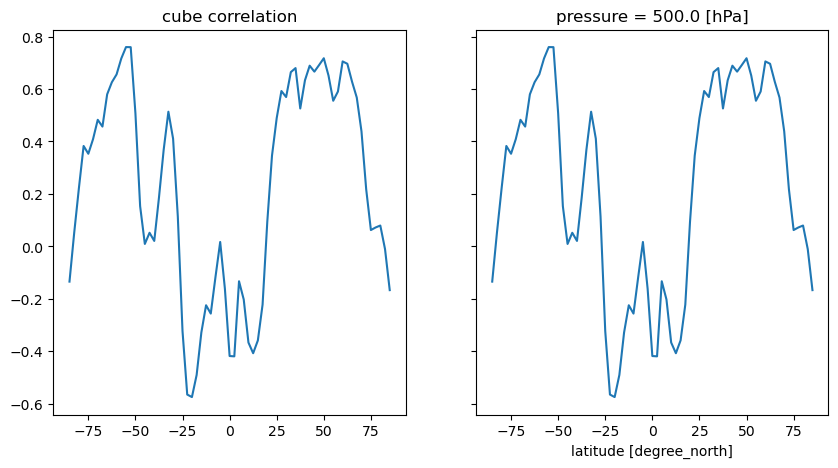

In [102]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,5), sharey=True)

ax1.plot(r_cube.coord('latitude').points, r_cube.data)
ax1.set_title('cube correlation')

r.plot(ax=ax2)

### Correlation checkpoint

In [89]:
np.testing.assert_allclose(r.values, r_cube.data, rtol=1e-04)

/home/users/cturrell/miniforge3/envs/eddy/lib/python3.12/site-packages/dask/array/numpy_compat.py:51: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


In [81]:
RR = r*np.cos( np.deg2rad(ds.latitude) )
R_weighted = RR.sum('latitude') / (np.cos( np.deg2rad(ds.latitude) )).sum('latitude')
R_weighted.values 

/home/users/cturrell/miniforge3/envs/eddy/lib/python3.12/site-packages/dask/array/numpy_compat.py:51: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


array(0.10629667)